### Setting up

In [1]:
spark

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 6, Finished, Available)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.types import BooleanType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml import Pipeline
from tabulate import tabulate
from functools import reduce

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 19, Finished, Available)

### Loading data

In [3]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

comments_path = "/basketball_comments_sentiment.parquet"
submissions_path = "/basketball_submissions_sentiment.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 8, Finished, Available)

In [4]:
submissions.show(5)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 9, Finished, Available)

+-----------------+------+--------------------+--------------------+--------------------+-------------------+------------+--------------+-----------+------------+------------+------------+----------------+-----------+--------------+---+-----+----+--------------------+--------+
|        subreddit|author|   author_flair_text|               title|            selftext|        created_utc|num_comments|supported_team|game_thread|home_ranking|   home_team|away_ranking|       away_team|  game_time|ranked_matchup|day|month|year|          clean_text|     col|
+-----------------+------+--------------------+--------------------+--------------------+-------------------+------------+--------------+-----------+------------+------------+------------+----------------+-----------+--------------+---+-----+----+--------------------+--------+
|CollegeBasketball|cbbBot|:rcbb: :ncaa: /r/...|[Game Thread] #3 ...|[UCLA](#f/ucla) *...|2022-02-04 00:00:04|        1172|          rcbb|       true|           5|    

In [6]:
# Rename col sentiment
submissions = submissions.withColumnRenamed("col", "sentiment")
comments = comments.withColumnRenamed("col", "sentiment")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 11, Finished, Available)

In [18]:
submissions.count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 23, Finished, Available)

9163

In [19]:
comments.count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 24, Finished, Available)

869804

### Sentiment Analysis on each team

In [7]:
# Define a dictionary of teams and associated keywords
team_keywords = {
    'houston': ['houston', 'cougars', 'uh', 'uh cougars'],
    'kansas': ['kansas', 'jayhawks', 'ku', 'rock chalk', 'ku jayhawks'],
    'villanova': ['villanova', 'wildcats', 'nova', 'villanova wildcats'],
    'duke': ['duke', 'blue devils', 'duke blue devils'],
    'arkansas': ['arkansas', 'razorbacks', 'hogs', 'u of a', 'arkansas razorbacks'],
    'saint peters': ["saint peter's", 'peacocks', "saint peter's peacocks", 'saint peters', "st. peter's", 'st peters', 'spu'],
    'north carolina': ['north carolina', 'tar heels', 'unc', 'unc tar heels'],
    'miami': ['miami', 'hurricanes', 'um', 'miami hurricanes'],
    'purdue': ['purdue', 'boilermakers', 'purdue boilermakers', 'pu'],
    'illinois': ['illinois', 'fighting illini', 'illini', 'u of i', 'university of illinois']
}

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 12, Finished, Available)

In [8]:
# Define the UDF to check the existence of key words
def keyword_present(text, keywords):
    if text:
        return any(keyword in text for keyword in keywords)
    return False

keyword_udf = udf(keyword_present, BooleanType())

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 13, Finished, Available)

In [9]:
# Apply the UDF
for team, keywords in team_keywords.items():
    submissions = submissions.withColumn(
        team,
        keyword_udf(col("title"), array([lit(k) for k in keywords])) | keyword_udf(col("selftext"), array([lit(k) for k in keywords]))
    )
    comments = comments.withColumn(
        team, 
        keyword_udf(col("body"), array([lit(k) for k in keywords]))
    )

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 14, Finished, Available)

In [10]:
# Check
submissions.printSchema

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 15, Finished, Available)

<bound method DataFrame.printSchema of DataFrame[subreddit: string, author: string, author_flair_text: string, title: string, selftext: string, created_utc: timestamp, num_comments: bigint, supported_team: string, game_thread: boolean, home_ranking: string, home_team: string, away_ranking: string, away_team: string, game_time: string, ranked_matchup: boolean, day: int, month: int, year: int, clean_text: string, sentiment: string, houston: boolean, kansas: boolean, villanova: boolean, duke: boolean, arkansas: boolean, saint peters: boolean, north carolina: boolean, miami: boolean, purdue: boolean, illinois: boolean]>

In [15]:
from pyspark.sql.functions import sum as sql_sum

# Define the function to aggregate counts by sentiment and team
def aggregate_counts_by_sentiment_and_team(df):
    aggregated_dfs = [df.groupBy("sentiment").agg(sql_sum(col(team).cast("int")).alias(team)) for team in team_keywords.keys()]
    return reduce(lambda df1, df2: df1.join(df2, "sentiment", "outer"), aggregated_dfs)


# Aggregate the counts for submissions by sentiment and team
submissions_aggregated = aggregate_counts_by_sentiment_and_team(submissions)

# Aggregate the counts for comments by sentiment and team
comments_aggregated = aggregate_counts_by_sentiment_and_team(comments)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 20, Finished, Available)

In [16]:
print("Team Mentions and Sentiment Proportion in Submissions")
submissions_aggregated.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 21, Finished, Available)

Team Mentions and Sentiment Proportion in Submissions
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
|sentiment|houston|kansas|villanova|duke|arkansas|saint peters|north carolina|miami|purdue|illinois|
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
| negative|     71|   173|      100|  42|      46|           0|           101|  308|   211|      81|
|  neutral|      2|    30|       25|   3|       2|           0|             8|   53|    15|       3|
| positive|    187|   462|      210| 113|     122|           4|           226| 2611|   404|     265|
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+



In [20]:
print("Team Mentions and Sentiment Proportion in Comments")
comments_aggregated.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 25, Finished, Available)

Team Mentions and Sentiment Proportion in Comments
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
|sentiment|houston|kansas|villanova|duke|arkansas|saint peters|north carolina|miami|purdue|illinois|
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
| negative|   1347|  3612|     2233|1111|     237|         359|          6283|19138| 15274|     253|
|  neutral|    190|   494|      307| 158|      41|          39|           849| 2428|  1908|      29|
| positive|   2518|  5109|     3573|1865|     462|         786|         11905|31182| 25010|     361|
+---------+-------+------+---------+----+--------+------------+--------------+-----+------+--------+



In [21]:
type(submissions_aggregated)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 26, Finished, Available)

pyspark.sql.dataframe.DataFrame

In [23]:
# Convert the Spark DataFrame to a Pandas DataFrame
submissions_aggregated_pd = submissions_aggregated.toPandas()
comments_aggregated_pd = comments_aggregated.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 28, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 43, Finished, Available)

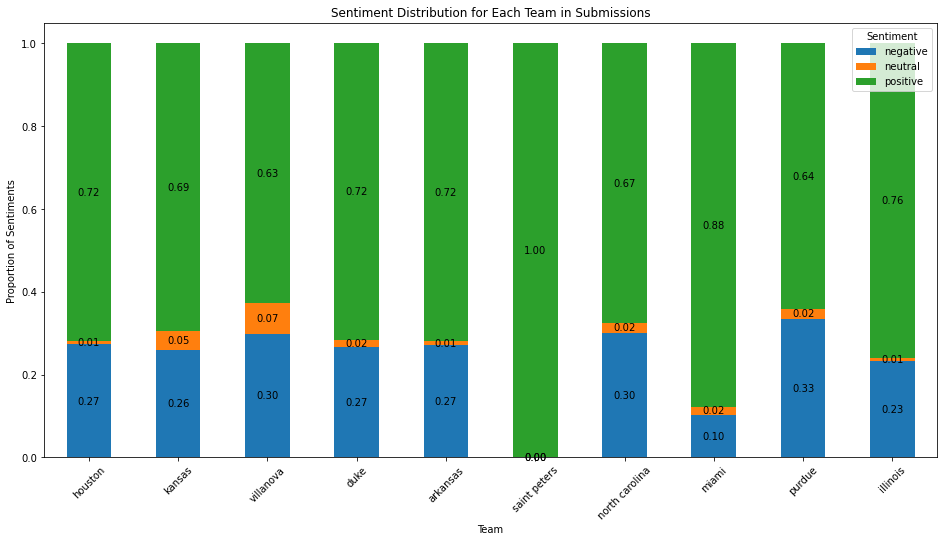

In [38]:
# Calculate the total counts for each team
submissions_total_counts = submissions_aggregated_pd.set_index('sentiment').sum()

# Calculate proportions
submissions_proportions = submissions_aggregated_pd.set_index('sentiment').div(submissions_total_counts)

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
bars = submissions_proportions.T.plot(kind='bar', stacked=True, ax=ax)

# Annotate each bar segment with its proportion
for bar in bars.containers:
    ax.bar_label(bar, fmt='%.2f', label_type='center')

ax.set_xlabel('Team')
ax.set_ylabel('Proportion of Sentiments')
ax.set_title('Sentiment Distribution for Each Team in Submissions')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.savefig("Users/yh706/fall-2023-reddit-project-team-26/data/plots/sentiment_distribution_for_each_team_in_submissions.png")
plt.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 51, 44, Finished, Available)

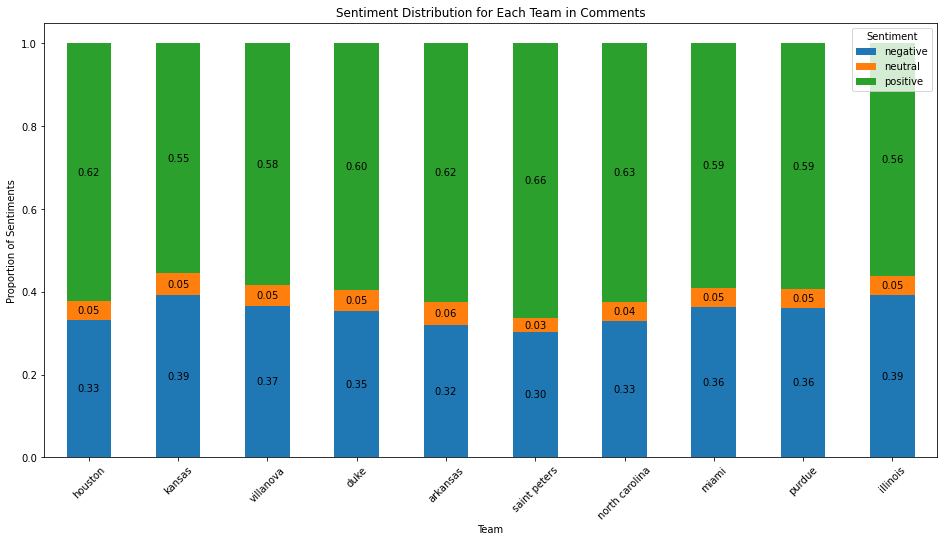

In [39]:
# Calculate the total counts for each team
comments_total_counts = comments_aggregated_pd.set_index('sentiment').sum()

# Calculate proportions
comments_proportions = comments_aggregated_pd.set_index('sentiment').div(comments_total_counts)

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
bars = comments_proportions.T.plot(kind='bar', stacked=True, ax=ax)

# Annotate each bar segment with its proportion
for bar in bars.containers:
    ax.bar_label(bar, fmt='%.2f', label_type='center')

ax.set_xlabel('Team')
ax.set_ylabel('Proportion of Sentiments')
ax.set_title('Sentiment Distribution for Each Team in Comments')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.savefig("Users/yh706/fall-2023-reddit-project-team-26/data/plots/sentiment_distribution_for_each_team_in_comments.png")
plt.show()